# Defining the train,test and model directories

In [17]:
import os
import pandas as pd
import pickle
import shutil
import numpy as np
import seaborn as sns
from sklearn.datasets import load_files
from keras.utils import np_utils
import matplotlib.pyplot as plt
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, AveragePooling2D, Flatten, Dense, Dropout, Input
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.utils.vis_utils import plot_model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
from keras.models import Model
from keras.layers.merge import concatenate
from PIL import ImageFile   
from sklearn.model_selection import train_test_split
from keras.preprocessing import image                  
from tqdm import tqdm
from keras.applications.resnet import ResNet50
import cv2
import tensorflow as tf

# Defining the train,test and model directories

In [2]:
TEST_DIR = 'imgs/test'
TRAIN_DIR = 'imgs/train'
MODEL_PATH = 'model/ResNet50'
PICKLE_PATH = 'pickle'
CSV_DIR = 'csv_files'

In [3]:
if not os.path.exists(TEST_DIR):
    print("Testing data does not exists")
if not os.path.exists(TRAIN_DIR):
    print("Training data does not exists")
if not os.path.exists(MODEL_PATH):
    print("Model ResNet path does not exists")
    os.makedirs(MODEL_PATH)
    print("Model ResNet path created")
if not os.path.exists(PICKLE_PATH):
    os.makedirs(PICKLE_DIR)
if not os.path.exists(CSV_DIR):
    os.makedirs(CSV_DIR)

# Data Preparation

In [4]:
data_train = pd.read_csv('csv_files/train.csv')
data_test = pd.read_csv('csv_files/test.csv')

### Converting into numerical values

In [5]:
labels_list = list(set(data_train['ClassName'].values.tolist()))
labels_id = {label_name:id for id,label_name in enumerate(labels_list)}
print(labels_id)
data_train['ClassName'].replace(labels_id,inplace=True)

{'c0': 0, 'c5': 1, 'c9': 2, 'c4': 3, 'c1': 4, 'c3': 5, 'c6': 6, 'c8': 7, 'c2': 8, 'c7': 9}


In [6]:
with open('pickle/labels_list.pkl', "wb") as handle:
    pickle.dump(labels_id,handle)

In [7]:
labels = to_categorical(data_train['ClassName'])
print(labels.shape)# Splitting into Train and Test sets

(22424, 10)


# Splitting into Train and Test sets

In [8]:
from sklearn.model_selection import train_test_split

xtrain,xtest,ytrain,ytest = train_test_split(data_train.iloc[:,0],labels,test_size = 0.2,random_state=42)

### Converting into 128*128 images

In [9]:
def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(128, 128))
    # convert PIL.Image.Image type to 3D tensor with shape (128, 128, 3)
    x = image.img_to_array(img)
   # convert 3D tensor to 4D tensor with shape (1, 128, 128, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)
def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [10]:
def path_to_img(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (128,128))
    x = np.asarray(img)
    return np.expand_dims(x, axis=0)

def paths_to_imgs(img_paths):
    list_of_imgs = [path_to_img(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_imgs)

In [ ]:
train_tensors = paths_to_imgs(xtrain)
valid_tensors = paths_to_imgs(xtest)

In [11]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras

train_tensors = paths_to_tensor(xtrain).astype('float32')/255 - 0.5
valid_tensors = paths_to_tensor(xtest).astype('float32')/255 - 0.5

100%|██████████████████████████████████████████████████████████████████████████████| 4485/4485 [01:22<00:00, 54.18it/s]


In [12]:
print(train_tensors.shape)

(17939, 128, 128, 3)


# ResNet50

In [18]:
model = ResNet50(include_top=False, input_shape = (128,128,3))
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [19]:
with tf.device('/CPU:0'):
    train_resnet50 = model.predict(train_tensors,verbose=1)
    valid_resnet50 = model.predict(valid_tensors,verbose=1)

141/141 [==============================] - 73s 497ms/step


In [20]:
print("Train shape",train_resnet50.shape)
print("Validation shape",valid_resnet50.shape)

Train shape (17939, 4, 4, 2048)
Validation shape (4485, 4, 4, 2048)


In [21]:
train_features = train_resnet50[0]
valid_features = valid_resnet50[0]

In [22]:
print("Train features shape",train_features.shape)
print("Validation features shape",valid_features.shape)

Train features shape (4, 4, 2048)
Validation features shape (4, 4, 2048)


In [23]:
ResNet50_model = Sequential()
ResNet50_model.add(GlobalAveragePooling2D(input_shape=train_features.shape))
ResNet50_model.add(Dense(10, activation='softmax', kernel_initializer='glorot_normal'))

ResNet50_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                20490     
Total params: 20,490
Trainable params: 20,490
Non-trainable params: 0
_________________________________________________________________


In [24]:
ResNet50_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [25]:
filepath = os.path.join(MODEL_PATH,"distracted-{epoch:02d}-{val_accuracy:.2f}.hdf5")
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max',period=1)
callbacks_list = [checkpoint]

In [26]:
model_history = ResNet50_model.fit(train_resnet50,ytrain,validation_data = (valid_resnet50, ytest),epochs=400, batch_size=16, shuffle=True, callbacks=callbacks_list)

Epoch 1/400
1122/1122 [==============================] - 15s 4ms/step - loss: 2.2652 - accuracy: 0.1532 - val_loss: 2.1227 - val_accuracy: 0.2745

Epoch 00001: val_accuracy improved from -inf to 0.27447, saving model to model/ResNet50\distracted-01-0.27.hdf5
Epoch 2/400
1122/1122 [==============================] - 4s 4ms/step - loss: 2.0887 - accuracy: 0.3046 - val_loss: 1.9864 - val_accuracy: 0.3460

Epoch 00002: val_accuracy improved from 0.27447 to 0.34604, saving model to model/ResNet50\distracted-02-0.35.hdf5
Epoch 3/400
1122/1122 [==============================] - 4s 4ms/step - loss: 1.9639 - accuracy: 0.3700 - val_loss: 1.8834 - val_accuracy: 0.4236

Epoch 00003: val_accuracy improved from 0.34604 to 0.42363, saving model to model/ResNet50\distracted-03-0.42.hdf5
Epoch 4/400
1122/1122 [==============================] - 4s 4ms/step - loss: 1.8625 - accuracy: 0.4262 - val_loss: 1.8012 - val_accuracy: 0.4531

Epoch 00004: val_accuracy improved from 0.42363 to 0.45307, saving model 

1122/1122 [==============================] - 4s 4ms/step - loss: 1.0200 - accuracy: 0.7248 - val_loss: 1.0041 - val_accuracy: 0.7338

Epoch 00036: val_accuracy improved from 0.71773 to 0.73378, saving model to model/ResNet50\distracted-36-0.73.hdf5
Epoch 37/400
1122/1122 [==============================] - 4s 4ms/step - loss: 1.0193 - accuracy: 0.7260 - val_loss: 0.9971 - val_accuracy: 0.7318

Epoch 00037: val_accuracy did not improve from 0.73378
Epoch 38/400
1122/1122 [==============================] - 4s 4ms/step - loss: 1.0034 - accuracy: 0.7315 - val_loss: 0.9915 - val_accuracy: 0.7266

Epoch 00038: val_accuracy did not improve from 0.73378
Epoch 39/400
1122/1122 [==============================] - 4s 4ms/step - loss: 0.9905 - accuracy: 0.7350 - val_loss: 0.9816 - val_accuracy: 0.7351

Epoch 00039: val_accuracy improved from 0.73378 to 0.73512, saving model to model/ResNet50\distracted-39-0.74.hdf5
Epoch 40/400
1122/1122 [==============================] - 4s 4ms/step - loss: 0.9872 

1122/1122 [==============================] - 4s 4ms/step - loss: 0.7726 - accuracy: 0.8016 - val_loss: 0.7753 - val_accuracy: 0.7835

Epoch 00073: val_accuracy did not improve from 0.79576
Epoch 74/400
1122/1122 [==============================] - 4s 4ms/step - loss: 0.7699 - accuracy: 0.8001 - val_loss: 0.7721 - val_accuracy: 0.7949

Epoch 00074: val_accuracy did not improve from 0.79576
Epoch 75/400
1122/1122 [==============================] - 4s 4ms/step - loss: 0.7640 - accuracy: 0.8031 - val_loss: 0.7614 - val_accuracy: 0.7996

Epoch 00075: val_accuracy improved from 0.79576 to 0.79955, saving model to model/ResNet50\distracted-75-0.80.hdf5
Epoch 76/400
1122/1122 [==============================] - 4s 4ms/step - loss: 0.7698 - accuracy: 0.8011 - val_loss: 0.7570 - val_accuracy: 0.8031

Epoch 00076: val_accuracy improved from 0.79955 to 0.80312, saving model to model/ResNet50\distracted-76-0.80.hdf5
Epoch 77/400
1122/1122 [==============================] - 4s 4ms/step - loss: 0.7583 

1122/1122 [==============================] - 4s 4ms/step - loss: 0.6565 - accuracy: 0.8311 - val_loss: 0.6599 - val_accuracy: 0.8259

Epoch 00110: val_accuracy did not improve from 0.82899
Epoch 111/400
1122/1122 [==============================] - 4s 4ms/step - loss: 0.6604 - accuracy: 0.8308 - val_loss: 0.6530 - val_accuracy: 0.8303

Epoch 00111: val_accuracy improved from 0.82899 to 0.83032, saving model to model/ResNet50\distracted-111-0.83.hdf5
Epoch 112/400
1122/1122 [==============================] - 4s 4ms/step - loss: 0.6475 - accuracy: 0.8312 - val_loss: 0.6490 - val_accuracy: 0.8308

Epoch 00112: val_accuracy improved from 0.83032 to 0.83077, saving model to model/ResNet50\distracted-112-0.83.hdf5
Epoch 113/400
1122/1122 [==============================] - 4s 4ms/step - loss: 0.6348 - accuracy: 0.8383 - val_loss: 0.6457 - val_accuracy: 0.8301

Epoch 00113: val_accuracy did not improve from 0.83077
Epoch 114/400
1122/1122 [==============================] - 4s 4ms/step - loss: 0


Epoch 00147: val_accuracy did not improve from 0.84705
Epoch 148/400
1122/1122 [==============================] - 4s 4ms/step - loss: 0.5816 - accuracy: 0.8511 - val_loss: 0.5867 - val_accuracy: 0.8462

Epoch 00148: val_accuracy did not improve from 0.84705
Epoch 149/400
1122/1122 [==============================] - 4s 4ms/step - loss: 0.5572 - accuracy: 0.8585 - val_loss: 0.5799 - val_accuracy: 0.8462

Epoch 00149: val_accuracy did not improve from 0.84705
Epoch 150/400
1122/1122 [==============================] - 4s 4ms/step - loss: 0.5726 - accuracy: 0.8490 - val_loss: 0.5842 - val_accuracy: 0.8410

Epoch 00150: val_accuracy did not improve from 0.84705
Epoch 151/400
1122/1122 [==============================] - 4s 4ms/step - loss: 0.5798 - accuracy: 0.8480 - val_loss: 0.5734 - val_accuracy: 0.8444

Epoch 00151: val_accuracy did not improve from 0.84705
Epoch 152/400
1122/1122 [==============================] - 4s 4ms/step - loss: 0.5600 - accuracy: 0.8576 - val_loss: 0.5767 - val_ac

1122/1122 [==============================] - 4s 4ms/step - loss: 0.5218 - accuracy: 0.8635 - val_loss: 0.5419 - val_accuracy: 0.8544

Epoch 00185: val_accuracy did not improve from 0.85886
Epoch 186/400
1122/1122 [==============================] - 4s 4ms/step - loss: 0.5175 - accuracy: 0.8658 - val_loss: 0.5397 - val_accuracy: 0.8528

Epoch 00186: val_accuracy did not improve from 0.85886
Epoch 187/400
1122/1122 [==============================] - 4s 4ms/step - loss: 0.5190 - accuracy: 0.8632 - val_loss: 0.5390 - val_accuracy: 0.8546

Epoch 00187: val_accuracy did not improve from 0.85886
Epoch 188/400
1122/1122 [==============================] - 4s 4ms/step - loss: 0.5252 - accuracy: 0.8622 - val_loss: 0.5364 - val_accuracy: 0.8586

Epoch 00188: val_accuracy did not improve from 0.85886
Epoch 189/400
1122/1122 [==============================] - 4s 4ms/step - loss: 0.5171 - accuracy: 0.8700 - val_loss: 0.5314 - val_accuracy: 0.8609

Epoch 00189: val_accuracy improved from 0.85886 to 0.8

1122/1122 [==============================] - 4s 4ms/step - loss: 0.4838 - accuracy: 0.8763 - val_loss: 0.4967 - val_accuracy: 0.8664

Epoch 00223: val_accuracy did not improve from 0.87046
Epoch 224/400
1122/1122 [==============================] - 4s 4ms/step - loss: 0.4888 - accuracy: 0.8733 - val_loss: 0.4991 - val_accuracy: 0.8629

Epoch 00224: val_accuracy did not improve from 0.87046
Epoch 225/400
1122/1122 [==============================] - 4s 4ms/step - loss: 0.4693 - accuracy: 0.8813 - val_loss: 0.5068 - val_accuracy: 0.8627

Epoch 00225: val_accuracy did not improve from 0.87046
Epoch 226/400
1122/1122 [==============================] - 4s 4ms/step - loss: 0.4826 - accuracy: 0.8734 - val_loss: 0.4987 - val_accuracy: 0.8633

Epoch 00226: val_accuracy did not improve from 0.87046
Epoch 227/400
1122/1122 [==============================] - 4s 4ms/step - loss: 0.4882 - accuracy: 0.8734 - val_loss: 0.4987 - val_accuracy: 0.8649

Epoch 00227: val_accuracy did not improve from 0.87046

1122/1122 [==============================] - 4s 4ms/step - loss: 0.4677 - accuracy: 0.8766 - val_loss: 0.4788 - val_accuracy: 0.8713

Epoch 00262: val_accuracy did not improve from 0.87492
Epoch 263/400
1122/1122 [==============================] - 4s 4ms/step - loss: 0.4536 - accuracy: 0.8835 - val_loss: 0.4746 - val_accuracy: 0.8693

Epoch 00263: val_accuracy did not improve from 0.87492
Epoch 264/400
1122/1122 [==============================] - 4s 4ms/step - loss: 0.4686 - accuracy: 0.8794 - val_loss: 0.4711 - val_accuracy: 0.8742

Epoch 00264: val_accuracy did not improve from 0.87492
Epoch 265/400
1122/1122 [==============================] - 4s 4ms/step - loss: 0.4505 - accuracy: 0.8805 - val_loss: 0.4799 - val_accuracy: 0.8678

Epoch 00265: val_accuracy did not improve from 0.87492
Epoch 266/400
1122/1122 [==============================] - 4s 4ms/step - loss: 0.4760 - accuracy: 0.8762 - val_loss: 0.4774 - val_accuracy: 0.8740

Epoch 00266: val_accuracy did not improve from 0.87492

1122/1122 [==============================] - 4s 4ms/step - loss: 0.4288 - accuracy: 0.8891 - val_loss: 0.4597 - val_accuracy: 0.8696

Epoch 00302: val_accuracy did not improve from 0.87871
Epoch 303/400
1122/1122 [==============================] - 4s 4ms/step - loss: 0.4284 - accuracy: 0.8882 - val_loss: 0.4530 - val_accuracy: 0.8774

Epoch 00303: val_accuracy did not improve from 0.87871
Epoch 304/400
1122/1122 [==============================] - 4s 4ms/step - loss: 0.4319 - accuracy: 0.8889 - val_loss: 0.4562 - val_accuracy: 0.8756

Epoch 00304: val_accuracy did not improve from 0.87871
Epoch 305/400
1122/1122 [==============================] - 4s 4ms/step - loss: 0.4464 - accuracy: 0.8847 - val_loss: 0.4521 - val_accuracy: 0.8751

Epoch 00305: val_accuracy did not improve from 0.87871
Epoch 306/400
1122/1122 [==============================] - 4s 4ms/step - loss: 0.4229 - accuracy: 0.8918 - val_loss: 0.4549 - val_accuracy: 0.8792

Epoch 00306: val_accuracy improved from 0.87871 to 0.8

1122/1122 [==============================] - 4s 4ms/step - loss: 0.4222 - accuracy: 0.8898 - val_loss: 0.4428 - val_accuracy: 0.8760

Epoch 00341: val_accuracy did not improve from 0.88339
Epoch 342/400
1122/1122 [==============================] - 4s 4ms/step - loss: 0.4196 - accuracy: 0.8896 - val_loss: 0.4390 - val_accuracy: 0.8774

Epoch 00342: val_accuracy did not improve from 0.88339
Epoch 343/400
1122/1122 [==============================] - 4s 4ms/step - loss: 0.4115 - accuracy: 0.8913 - val_loss: 0.4327 - val_accuracy: 0.8838

Epoch 00343: val_accuracy improved from 0.88339 to 0.88384, saving model to model/ResNet50\distracted-343-0.88.hdf5
Epoch 344/400
1122/1122 [==============================] - 4s 4ms/step - loss: 0.4101 - accuracy: 0.8900 - val_loss: 0.4378 - val_accuracy: 0.8812

Epoch 00344: val_accuracy did not improve from 0.88384
Epoch 345/400
1122/1122 [==============================] - 4s 4ms/step - loss: 0.4090 - accuracy: 0.8920 - val_loss: 0.4347 - val_accuracy: 0

1122/1122 [==============================] - 4s 4ms/step - loss: 0.3935 - accuracy: 0.8997 - val_loss: 0.4225 - val_accuracy: 0.8825

Epoch 00380: val_accuracy did not improve from 0.88562
Epoch 381/400
1122/1122 [==============================] - 4s 4ms/step - loss: 0.4024 - accuracy: 0.8957 - val_loss: 0.4271 - val_accuracy: 0.8807

Epoch 00381: val_accuracy did not improve from 0.88562
Epoch 382/400
1122/1122 [==============================] - 4s 4ms/step - loss: 0.3995 - accuracy: 0.8942 - val_loss: 0.4259 - val_accuracy: 0.8849

Epoch 00382: val_accuracy did not improve from 0.88562
Epoch 383/400
1122/1122 [==============================] - 4s 4ms/step - loss: 0.3909 - accuracy: 0.8986 - val_loss: 0.4279 - val_accuracy: 0.8814

Epoch 00383: val_accuracy did not improve from 0.88562
Epoch 384/400
1122/1122 [==============================] - 4s 4ms/step - loss: 0.4004 - accuracy: 0.8952 - val_loss: 0.4284 - val_accuracy: 0.8787

Epoch 00384: val_accuracy did not improve from 0.88562

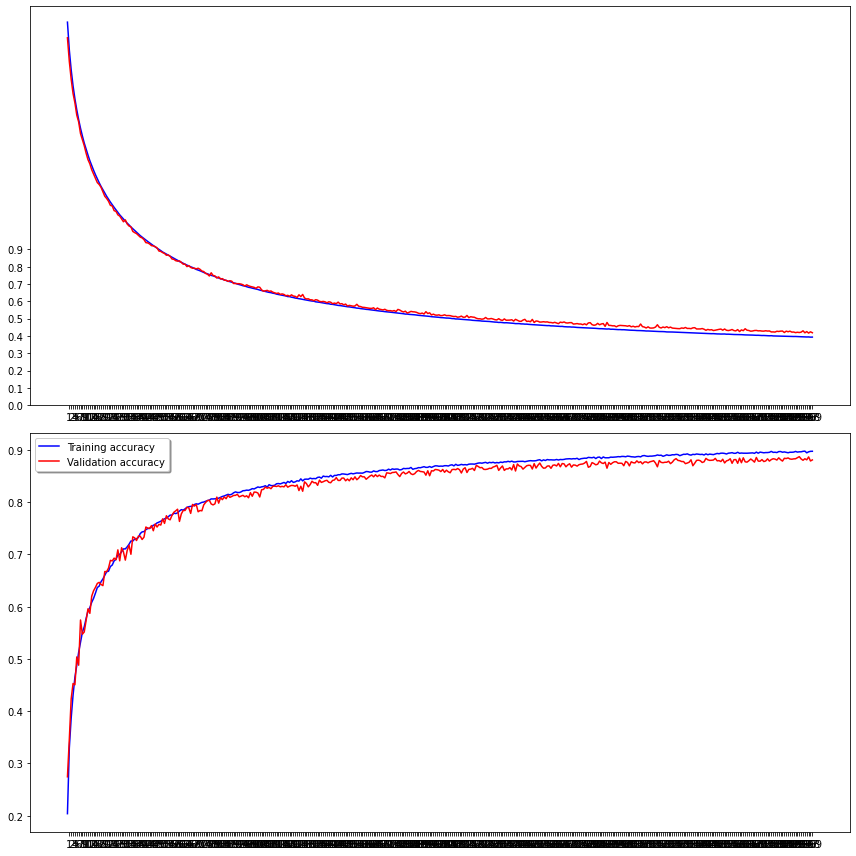

In [27]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(model_history.history['loss'], color='b', label="Training loss")
ax1.plot(model_history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, 400, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(model_history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(model_history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, 400, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [28]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    fig.savefig(os.path.join(MODEL_PATH,"confusion_matrix.png"))
    return fig

In [29]:
def print_heatmap(n_labels, n_predictions, class_names):
    labels = n_labels #sess.run(tf.argmax(n_labels, 1))
    predictions = n_predictions #sess.run(tf.argmax(n_predictions, 1))

#     confusion_matrix = sess.run(tf.contrib.metrics.confusion_matrix(labels, predictions))
    matrix = confusion_matrix(labels.argmax(axis=1),predictions.argmax(axis=1))
    row_sum = np.sum(matrix, axis = 1)
    w, h = matrix.shape

    c_m = np.zeros((w, h))

    for i in range(h):
        c_m[i] = matrix[i] * 100 / row_sum[i]

    c = c_m.astype(dtype = np.uint8)

    
    heatmap = print_confusion_matrix(c, class_names, figsize=(18,10), fontsize=20)

In [30]:
class_names = list()
for name,idx in labels_id.items():
    class_names.append(name)
# print(class_names)
ypred = ResNet50_model.predict(valid_resnet50,verbose=1)

141/141 [==============================] - 0s 3ms/step


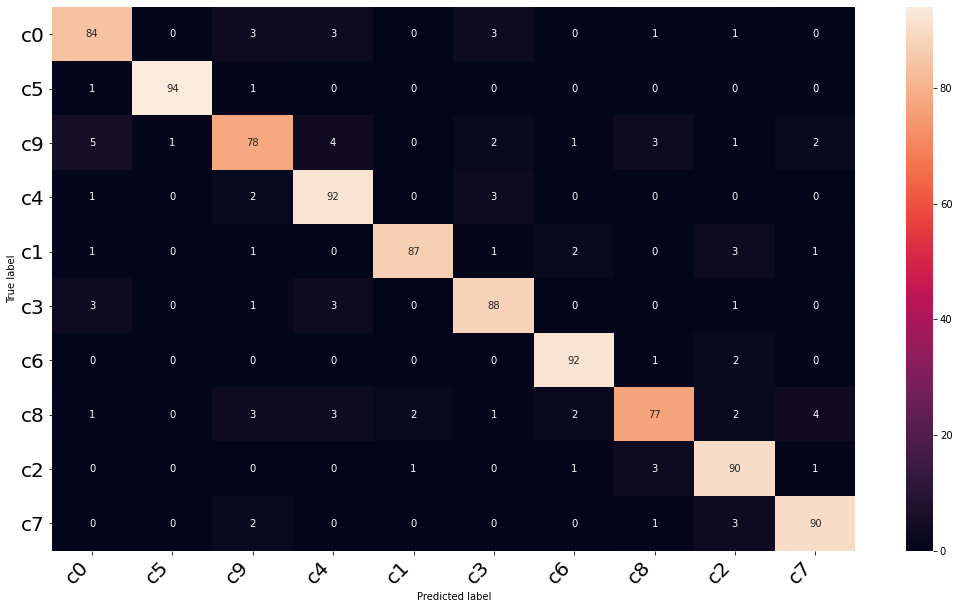

In [31]:
print_heatmap(ytest,ypred,class_names)

In [32]:
ypred_class = np.argmax(ypred,axis=1)
# print(ypred_class[:10])
ytest = np.argmax(ytest,axis=1)

In [33]:
accuracy = accuracy_score(ytest,ypred_class)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(ytest, ypred_class,average='weighted')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(ytest,ypred_class,average='weighted')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(ytest,ypred_class,average='weighted')
print('F1 score: %f' % f1)

Accuracy: 0.880936
Precision: 0.881518
Recall: 0.880936
F1 score: 0.880769
